# Get outing data from CampToCamp.org

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotly import express as px, graph_objects as go, subplots as sp
import requests as req
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import re
import io
from datetime import datetime
import itertools

In [2]:
url_c2c_api = 'https://api.camptocamp.org'
# Max 100 per request
page_len = 100

def get_url_outings(area: int, activity: str = 'skitouring', offset: int = 0):
    return url_c2c_api + f'/outings?a={area}&act={activity}&limit={page_len}&offset={offset}'

def get_url_outing(id: int):
    return url_c2c_api + f'/outings/{id}'

In [3]:
cols_base1 = ['id', 'title']
cols_base2 = ['date_start', 'date_end', 'labande_global_rating', 'ski_rating', 'elevation_max', 'height_diff_up', 'condition_rating', 'quality']
cols_ext = ['elevation_min', 'elevation_up_snow', 'elevation_down_snow', 'snow_quality', 'snow_quantity', 'frequentation']

#### Mappers for ordinal columns

In [131]:
ski_rating_mapper = {**{f'{i+1}.{j+1}': 3*i + j for i,j in itertools.product(range(5), range (3))}, '5.4': 15, '5.5': 16, '5.6': 17}
rate_mapper = {'awful': 0, 'poor': 1, 'average': 2, 'good': 3, 'excellent': 4}

### Season

winter season spans over two consecutive years

Day of year "centered" on winter with index 0 for February 15th

In [107]:
mid_season = datetime.fromisoformat('2020-02-15').timetuple().tm_yday
mid_season

46

In [108]:
season_limit_day = mid_season + 182
season_offset = mid_season + 365

## Attach temperature

Taking a single temperature reference in Megève, based on data from [historique-meteo.net](https://www.historique-meteo.net/france/rh-ne-alpes/megeve/)

In [150]:
url_temperature_megeve = 'https://www.historique-meteo.net/site/export.php?ville_id=6011'
s = req.get(url_temperature_megeve).content
df_temperature = pd.read_csv(io.StringIO(s.decode('utf-8')), skiprows=3, sep=',')
df_temperature['date'] = pd.to_datetime(df_temperature['DATE'])

In [190]:
df_temperature['temp_morning_7d'] = df_temperature.TEMPERATURE_MORNING_C.rolling(7).mean()
df_temperature['temp_morning_30d'] = df_temperature.TEMPERATURE_MORNING_C.rolling(30).mean()

## Fetch data from Camptocamp.org

In [4]:
def read_outing(id):
    """ Get and extract wanted information from an outing """
    doc = req.get(get_url_outing(id)).json()
    title = doc['locales'][0]['title'] if len(doc['locales']) > 0 else ''
    cols_base2_values = {f: doc[f] for f in cols_base2}
    cols_ext_values = {f: doc[f] for f in cols_ext}
    return dict(id=id, title=title, **cols_base2_values, **cols_ext_values)

In [9]:
def map_outing(doc):
    title = doc['locales'][0]['title'] if len(doc['locales']) > 0 else ''
    cols_base2_values = {f: doc[f] for f in cols_base2}
    return {'id': doc['document_id'], 'title': title, **cols_base2_values}

def process_area_outings(area_id: int, area_title: str, extended_data: bool = True, write_down: bool = False):

    cols = cols_base1 + cols_base2
    if extended_data:
        cols += cols_ext
    
    df_outings = pd.DataFrame(columns=cols)
    try:
        # Get first page in order to get total number of outings
        page_offset = 0
        outing_list = req.get(get_url_outings(area_id, offset=page_offset)).json()
        nb_outings = outing_list['total']
        print(f'Number of outings {nb_outings} for {area_title}')

        # Iterate
        cnt_outings = 0
        cnt_iter = 0
        print('page offset:', end=' ')
        while cnt_outings < nb_outings and cnt_iter < 1000: 
            print(page_offset, end=', ')
            rows = []
            if 'documents' not in outing_list:
                raise ValueError('End at offset: ' + page_offset)

            if extended_data:
                for outing_doc in outing_list['documents']:
                    outing_data = read_outing(outing_doc['document_id'])
                    rows.append(outing_data)
                    cnt_outings += 1
            else:
                rows = list(map(map_outing, outing_list['documents']))
            df_outings = df_outings.append(rows)
            page_offset += len(outing_list['documents'])
            outing_list = req.get(get_url_outings(area_id, offset=page_offset)).json()
            cnt_iter += 1

        print('download completed')
       
    except Exception as e:
        print('Exception raised!:', str(e))
    
    # Complete columns and cleanup
    df_outings['area_id'] = area_id
    
    df_outings['date_start'] = pd.to_datetime(df_outings['date_start'])
    df_outings['date_end'] = pd.to_datetime(df_outings['date_end'])
    
    # Map ordinal to integers
    df_outings['ski_rating_num']  = df_outings.loc[df_outings.ski_rating != None, ['ski_rating']].replace(ski_rating_mapper)
    df_outings['condition_rating_num'] = df_outings.loc[df_outings.condition_rating != None, ['condition_rating']].replace(rate_mapper)
    df_outings['snow_quantity_num'] = df_outings.loc[df_outings.snow_quantity != None, ['snow_quantity']].replace(rate_mapper)
    df_outings['snow_quality_num'] = df_outings.loc[df_outings.snow_quality != None, ['snow_quality']].replace(rate_mapper)
        
    # Fill missing up/down on skis elevations
    df_outings.elevation_up_snow = df_outings.elevation_up_snow.fillna(df_outings.elevation_min)
    df_outings.elevation_down_snow = df_outings.elevation_down_snow.fillna(df_outings.elevation_min)
      
    # Season and day within season
    df_outings['day_of_season'] = df_outings.date_start.dt.dayofyear.apply(lambda d: d - season_offset if d > season_limit_day else d - mid_season)
    df_outings['season'] = df_outings.date_start.dt.year
    df_outings.loc[df_outings.day_of_season < 0, ['season']] = df_outings.loc[df_outings.day_of_season < 0, ['season']].apply(lambda y: y + 1) 
       
    # Temperature
    df_outings = pd.merge(df_outings, df_temperature[['TEMPERATURE_MORNING_C', 'temp_morning_7d', 'temp_morning_30d']], left_on='date_start', right_on='date')
        
    # Write to Parquet
    if write_down:
        df_outings.to_parquet(f'data/C2C/outings_{area_title}.parquet', compression='GZIP')
        
    return df_outings

In [10]:
df_outings = process_area_outings(14366, 'haute-savoie', write_down=True)
len(df_outings)

Number of outings 17465 for haute-savoie
page offset: 0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900, 10000, end at offset: 10000


10000

In [11]:
df_outings.head(3)

id                                              title  date_start  \
0  1260741                     Dômes de Miage : Face N (5.3)   2020-11-02   
1  1259728  Grandes Jorasses - Pointe Walker : Colton - Ma...  2020-11-01   
2  1255933   Mont Blanc : Par les Grands Mulets -  STOP 4000m  2020-10-17   

     date_end labande_global_rating ski_rating elevation_max height_diff_up  \
0  2020-11-02                    TD        5.3          3673           2200   
1  2020-11-02                  None       None          4208           1800   
2  2020-10-18                    AD        3.2          4810           3600   

  condition_rating quality  elevation_min  elevation_up_snow  \
0          average    fine         2600.0             2600.0   
1        excellent    fine            NaN                NaN   
2             good  medium         1269.0                NaN   

   elevation_down_snow snow_quality snow_quantity frequentation  area_id  
0               2400.0         poor       average         quiet    14366  
1                  NaN         None          None          some    14366  
2                  NaN         good          None          None    14366

#### Map ordinal attributes from string to int

In [13]:
df_outings.quality.unique()

array(['fine', 'medium', 'great', 'draft', 'empty'], dtype=object)

In [14]:
df_outings.labande_global_rating.unique(), df_outings.ski_rating.unique(), 

(array(['TD', None, 'AD', 'F', 'PD-', 'AD+', 'D', 'TD-', 'ED', 'PD', 'D+',
        'AD-', 'PD+', 'F+', 'ED+', 'D-', 'TD+', 'ED-'], dtype=object),
 array(['5.3', None, '3.2', '1.2', '2.3', '3.3', '4.2', '5.1', '5.2',
        '5.4', '4.3', '3.1', '1.3', '5.5', '2.1', '2.2', '1.1', '4.1',
        '5.6'], dtype=object))

In [15]:
df_outings.condition_rating.unique(), df_outings.snow_quality.unique(), df_outings.snow_quantity.unique()

(array(['average', 'excellent', 'good', None, 'poor', 'awful'],
       dtype=object),
 array(['poor', None, 'good', 'average', 'excellent', 'awful'],
       dtype=object),
 array(['average', None, 'good', 'excellent', 'poor', 'awful'],
       dtype=object))

In [18]:
df_outings.elevation_up_snow.isna().sum(), df_outings.elevation_down_snow.isna().sum(), df_outings.elevation_min.isna().sum(), df_outings.elevation_max.isna().sum()

(837, 882, 7356, 1209)

### Distributions (histograms)

#### Report quality 

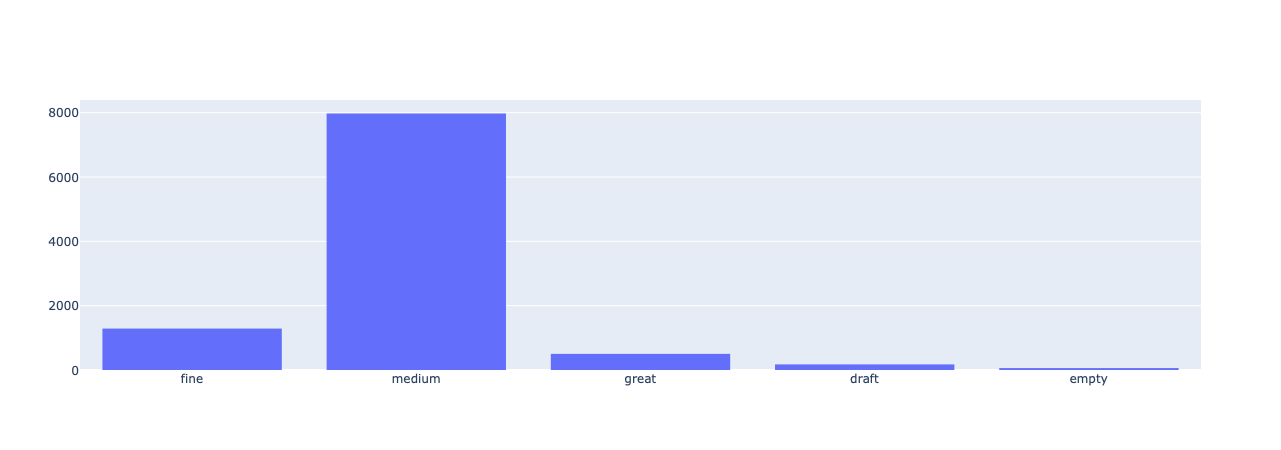

In [61]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=df_outings['quality']))

#### Qualitative attributes

In [58]:
df_outings['condition_rating'].isna().sum(), df_outings['snow_quality'].isna().sum(), df_outings['snow_quantity'].isna().sum()

(876, 8126, 8216)

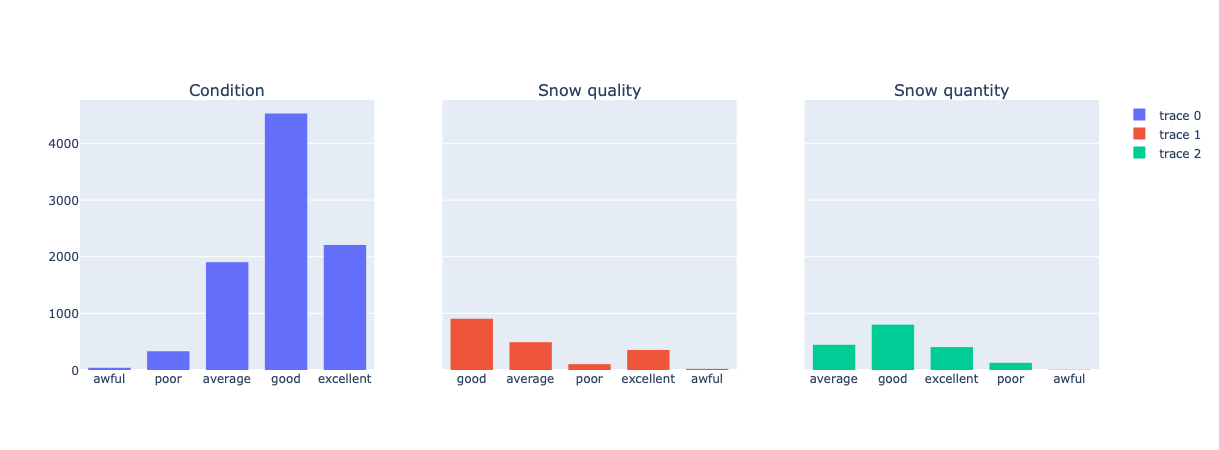

In [204]:
fig = sp.make_subplots(cols=3, rows=1, shared_yaxes=True, subplot_titles=['Condition', 'Snow quality', 'Snow quantity'])
labels_ratings = {'condition_rating_num': 'Condition', 'snow_quality_num': 'Snow quality', 'snow_quantity_num': 'Snow quantity' }
fig.update_layout(bargroupgap=0.1, xaxis=dict(categoryorder='array', categoryarray=list(rate_mapper.keys()), type='category'))
fig.add_trace(go.Histogram(x=df_outings['condition_rating']), col=1, row=1)
fig.add_trace(go.Histogram(x=df_outings['snow_quality']), col=2, row=1)
fig.add_trace(go.Histogram(x=df_outings['snow_quantity']), col=3, row=1)

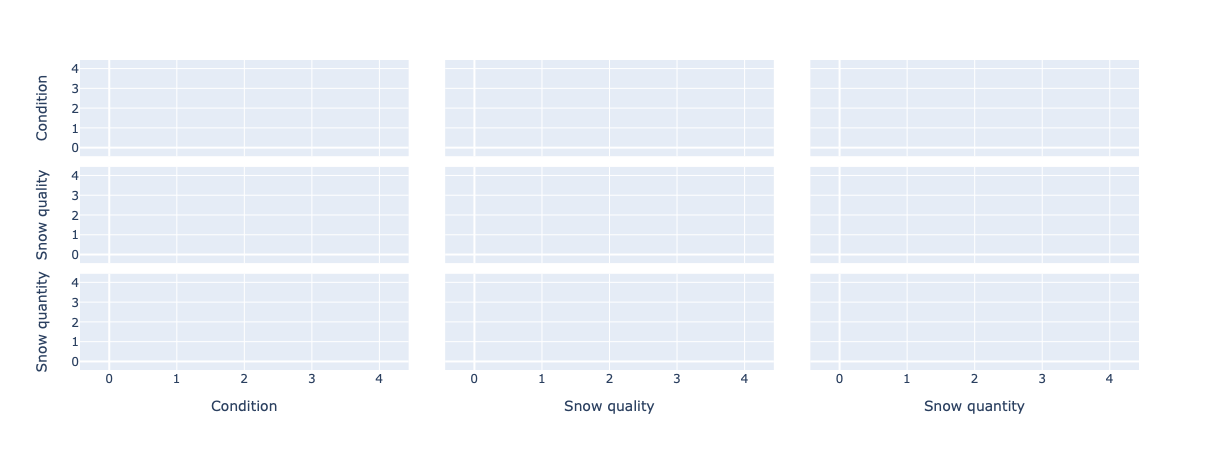

In [43]:
px.scatter_matrix(df_outings[['condition_rating_num', 'snow_quality_num', 'snow_quantity_num']], labels=labels_ratings)

#### Elevations

Elevation [m]


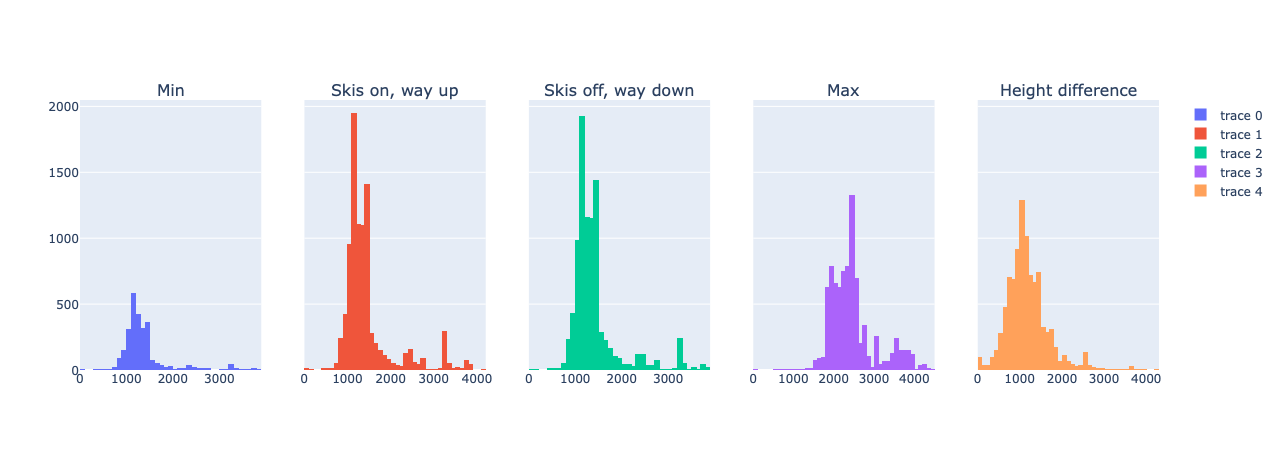

In [24]:
print('Elevation [m]')
fig = sp.make_subplots(rows=1, cols=5, shared_yaxes=True, subplot_titles=['Min', 'Skis on, way up', 'Skis off, way down', 'Max', 'Height difference'])
bins = {'start': 0, 'end': 4500, 'size': 100}
fig.add_trace(go.Histogram(x=df_outings['elevation_min'], xbins=bins), row=1, col=1)
fig.add_trace(go.Histogram(x=df_outings['elevation_up_snow'], xbins=bins), row=1, col=2)
fig.add_trace(go.Histogram(x=df_outings['elevation_down_snow'], xbins=bins), row=1, col=3)
fig.add_trace(go.Histogram(x=df_outings['elevation_max'], xbins=bins), row=1, col=4)
fig.add_trace(go.Histogram(x=df_outings['height_diff_up'], xbins=bins, ), row=1, col=5)

The most populated fields are by decreasing order: 'height_diff_up' , 'elevation_up_snow', 'elevation_down_snow', 'elevation_max'

In [53]:
df_outings['elevation_min'].count(), df_outings['elevation_max'].count(), df_outings['height_diff_up'].count()

(2644, 8791, 9574)

In [54]:
df_outings['elevation_up_snow'].count(), df_outings['elevation_down_snow'].count(), (df_outings['elevation_up_snow'] == df_outings['elevation_down_snow']).sum()

(9163, 9118, 8214)

#### Ski difficulty

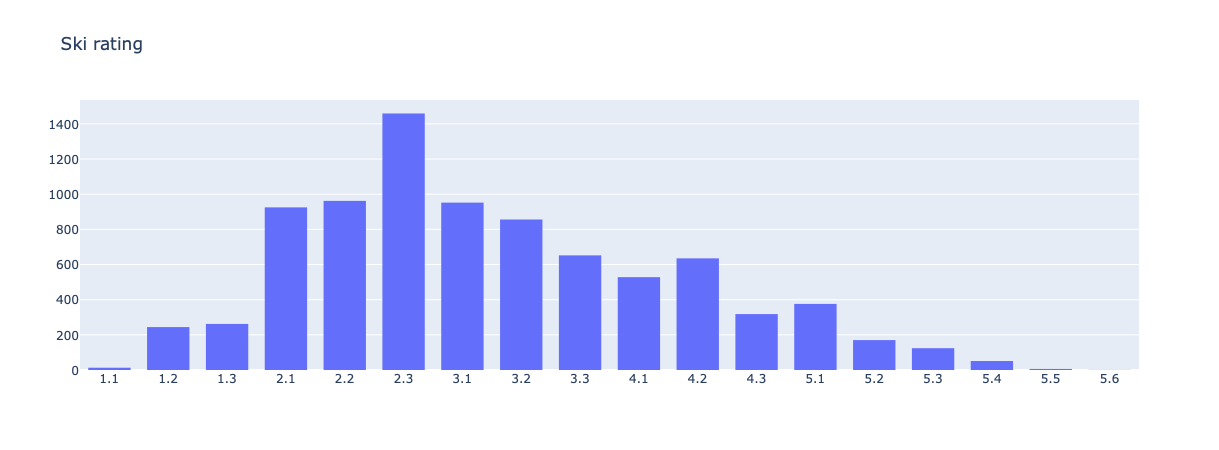

In [202]:
fig = go.Figure(layout=dict(title='Ski rating', bargroupgap=0.1))
fig.add_trace(go.Histogram(x=df_outings.ski_rating))
fig.update_layout(xaxis=dict(categoryorder='array', categoryarray=list(ski_rating_mapper.keys()), type="category"))

#### Date

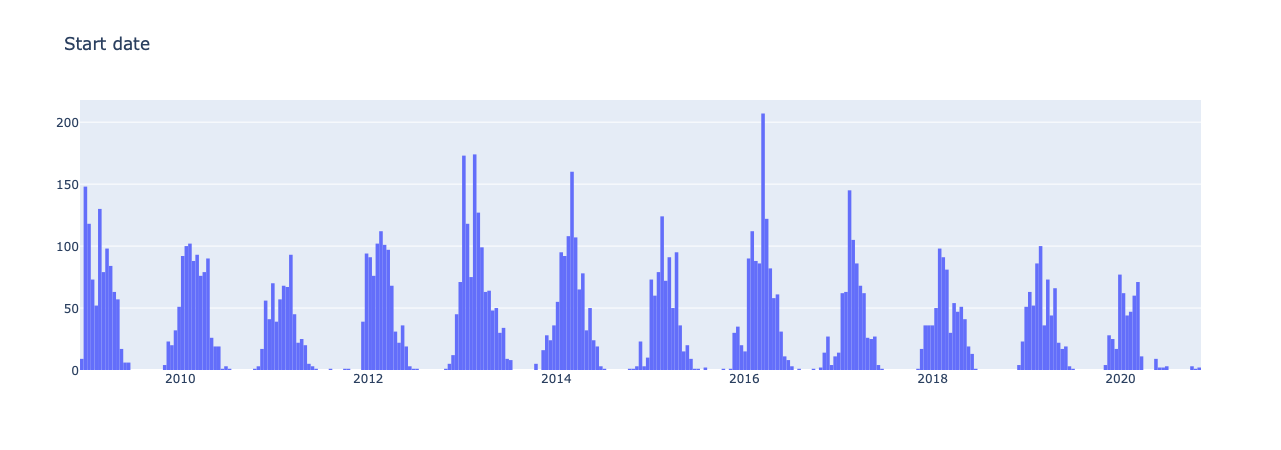

In [85]:
fig = go.Figure(layout=dict(title='Start date', bargroupgap=0.01))
fig.add_trace(go.Histogram(x=df_outings.date_start, nbinsx=500))

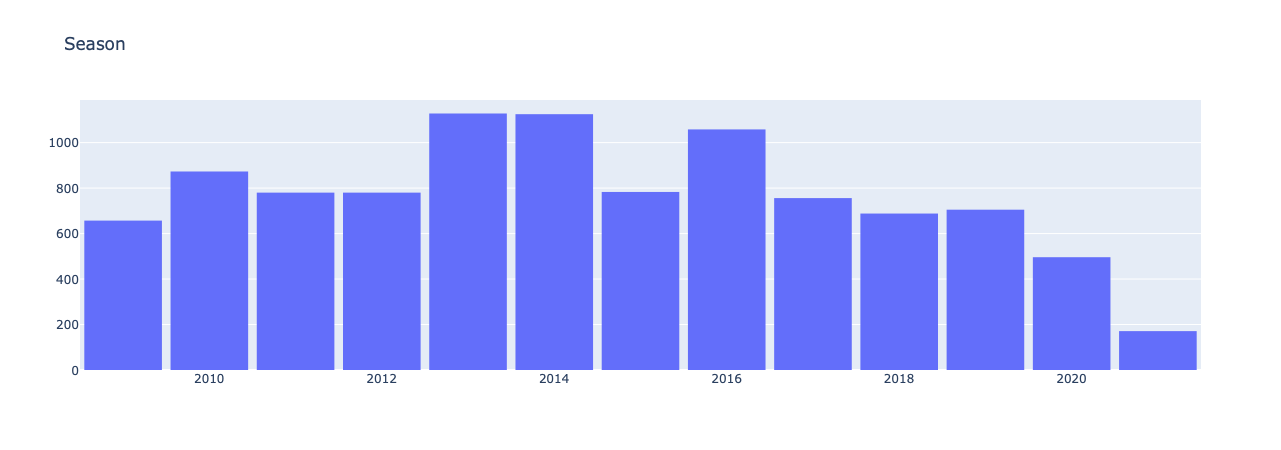

In [114]:
fig = go.Figure(layout=dict(title='Season', bargroupgap=0.1))
fig.add_histogram(x=df_outings.season)

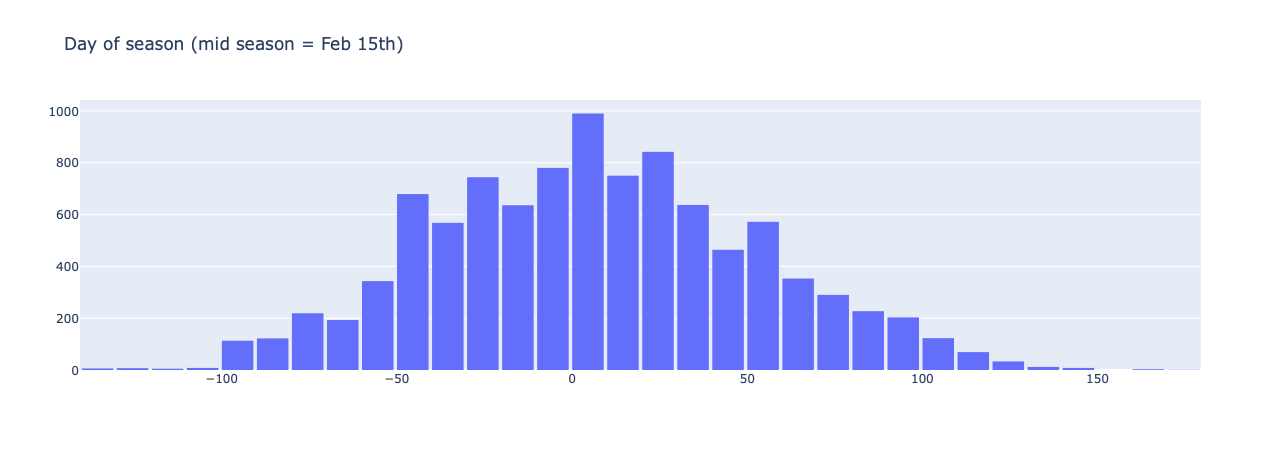

In [122]:
fig = go.Figure(layout=dict(title='Day of season (mid season = Feb 15th)', bargroupgap=0.1))
fig.add_histogram(x=df_outings.day_of_season, nbinsx=52)

#### Morning temperature

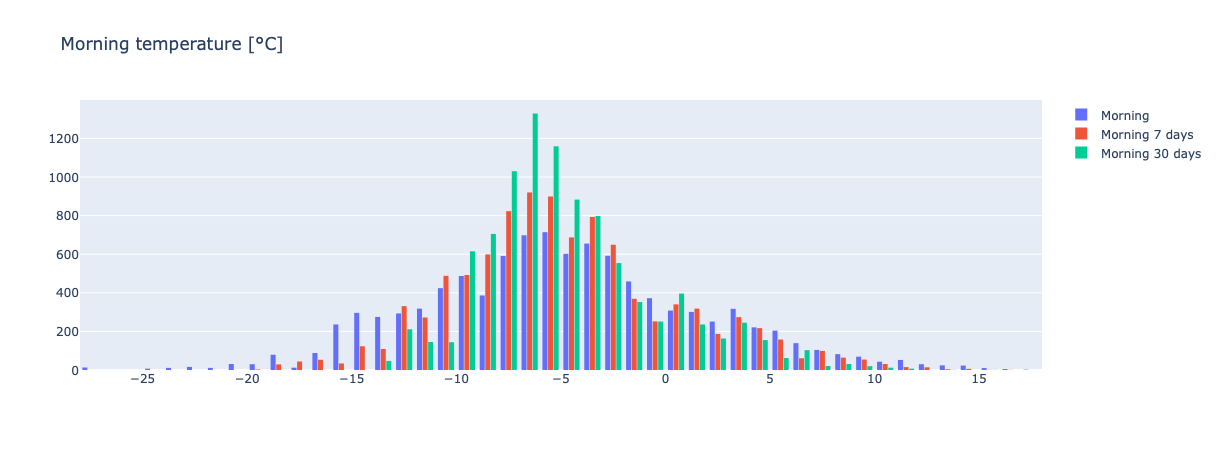

In [195]:
fig = go.Figure(layout=dict(title='Morning temperature [°C]', bargroupgap=0.1))
bins = {'start': -35, 'end': 30, 'size': 1}
fig.add_histogram(x=df_outings.TEMPERATURE_MORNING_C, name='Morning', xbins=bins)
fig.add_histogram(x=df_outings.temp_morning_7d, name='Morning 7 days', xbins=bins)
fig.add_histogram(x=df_outings.temp_morning_30d, name='Morning 30 days', xbins=bins)

## Comparison beginning and end of period

Taking:
- beginning as: 2010-2012, 
- end as: 2017-2019 (2020 is special with Covid lock-down)

In [206]:
df_sel_begin = df_outings[df_outings.season.isin([2010, 2011, 2012])]
df_sel_end = df_outings[df_outings.season.isin([2017, 2018, 2019])]
len(df_sel_begin), len(df_sel_end)

(2433, 2149)

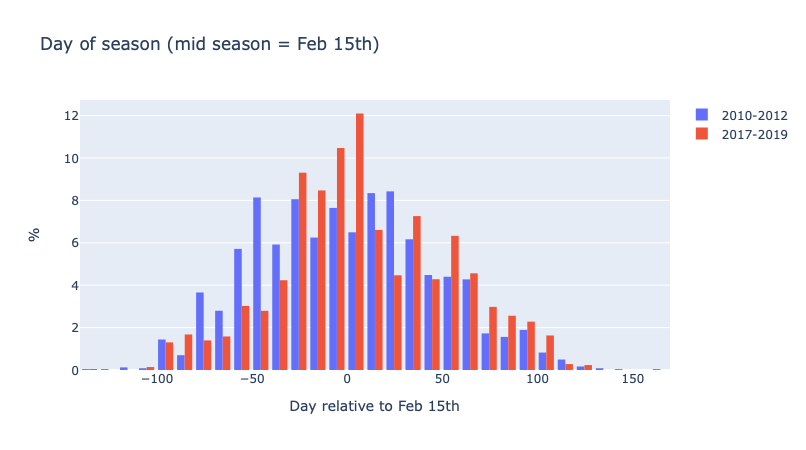

In [135]:
fig = go.Figure(layout=dict(title='Day of season (mid season = Feb 15th)', bargroupgap=0.01, 
                            xaxis=dict(title='Day relative to Feb 15th'), yaxis=dict(title='%')))
fig.add_histogram(x=df_sel_begin.day_of_season, name='2010-2012', nbinsx=52, histnorm='percent')
fig.add_histogram(x=df_sel_end.day_of_season, name='2017-2019', nbinsx=52, histnorm='percent')

Comment: there are a lot less outing early season in 2017-2019. There is a little more outing at the end of the season, but the tail is also shorter.

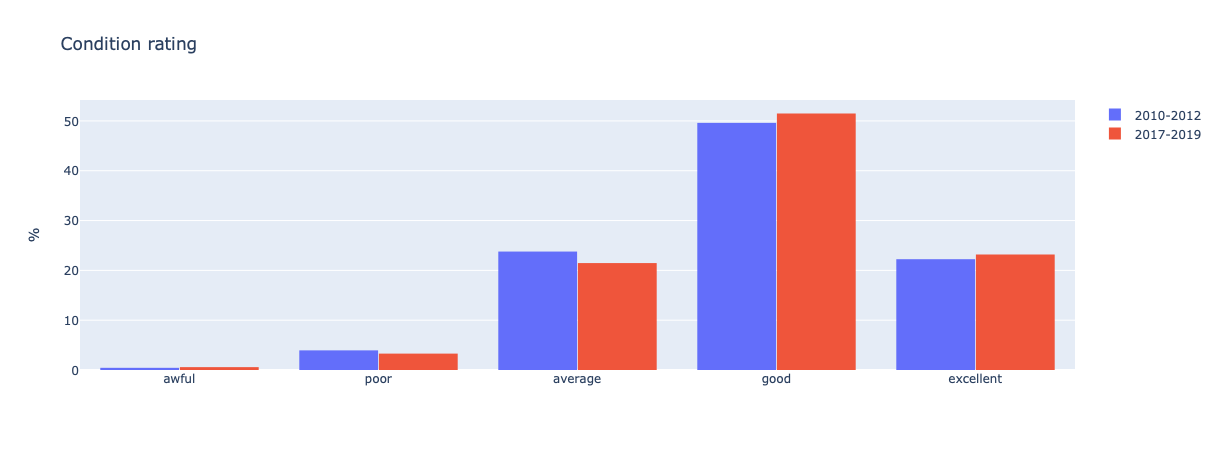

In [205]:
fig = go.Figure(layout=dict(title='Condition rating', bargroupgap=0.01, yaxis=dict(title='%'), 
                            xaxis=dict(categoryorder='array', categoryarray=list(rate_mapper.keys()), type='category')))
fig.add_histogram(x=df_sel_begin.condition_rating, name='2010-2012', histnorm='percent')
fig.add_histogram(x=df_sel_end.condition_rating, name='2017-2019', histnorm='percent')

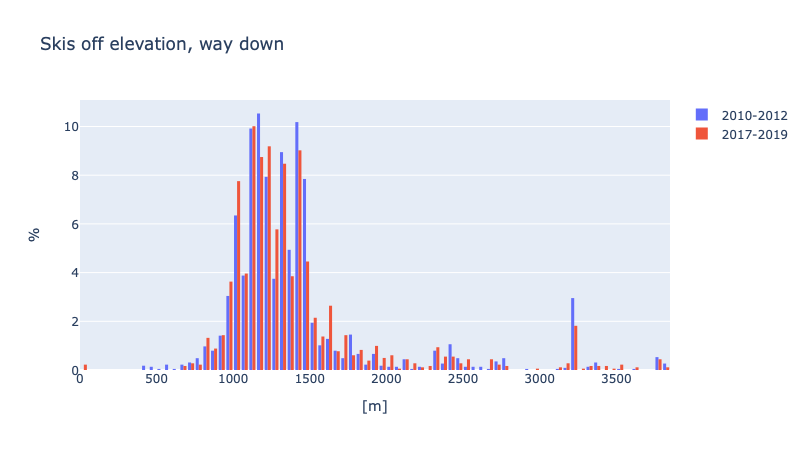

In [134]:
fig = go.Figure(layout=dict(title='Skis off elevation, way down', bargroupgap=0.01, 
                            xaxis=dict(title='[m]'), yaxis=dict(title='%')))
fig.add_histogram(x=df_sel_begin.elevation_down_snow, name='2010-2012', histnorm='percent')
fig.add_histogram(x=df_sel_end.elevation_down_snow, name='2017-2019', histnorm='percent')

Mean morning temperature, for 2010-2012=-6, for 2017-2019=-4.18


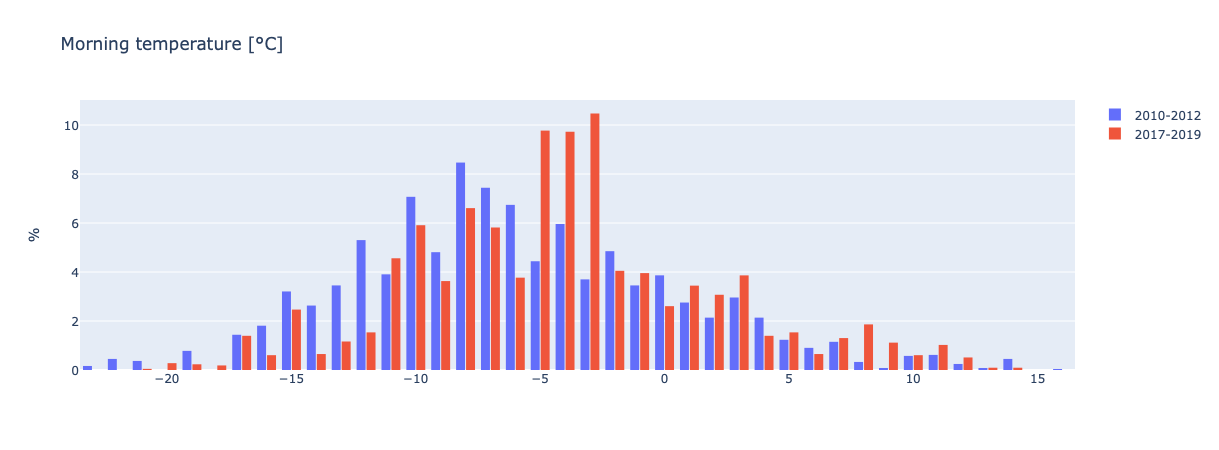

In [184]:
print(f'Mean morning temperature, for 2010-2012={df_sel_begin.TEMPERATURE_MORNING_C.mean():.3g}, for 2017-2019={df_sel_end.TEMPERATURE_MORNING_C.mean():.3g}')
fig = go.Figure(layout=dict(title='Morning temperature [°C]', bargroupgap=0.1, yaxis=dict(title='%')))
fig.add_histogram(x=df_sel_begin.TEMPERATURE_MORNING_C, name='2010-2012', histnorm='percent')
fig.add_histogram(x=df_sel_end.TEMPERATURE_MORNING_C, name='2017-2019', histnorm='percent')

Mean morning 7 day temperature, for 2010-2012=-5.38, for 2017-2019=-3.9


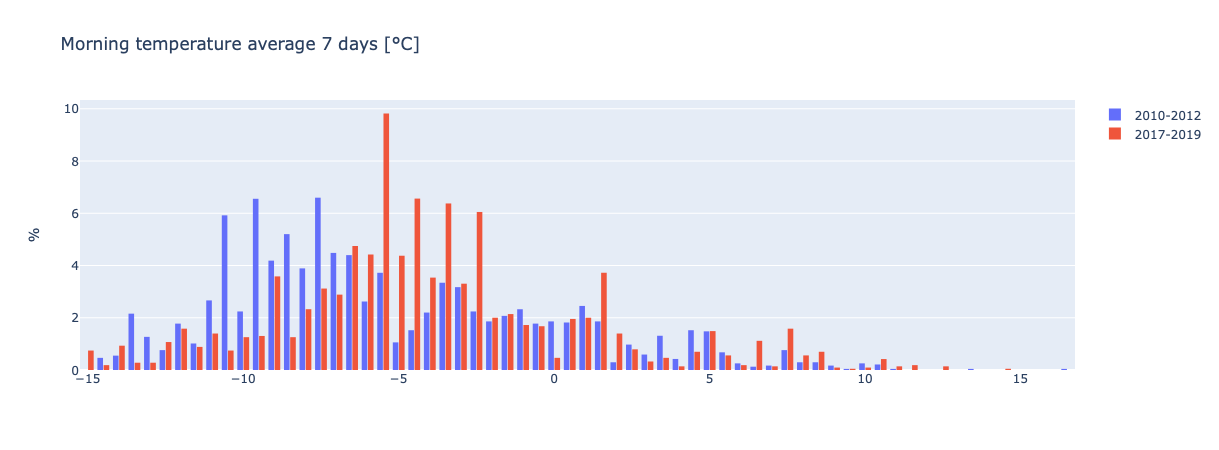

In [207]:
print(f'Mean morning 7 day temperature, for 2010-2012={df_sel_begin.temp_morning_7d.mean():.3g}, for 2017-2019={df_sel_end.temp_morning_7d.mean():.3g}')
fig = go.Figure(layout=dict(title='Morning temperature average 7 days [°C]', bargroupgap=0.1, yaxis=dict(title='%')))
fig.add_histogram(x=df_sel_begin.temp_morning_7d, name='2010-2012', histnorm='percent')
fig.add_histogram(x=df_sel_end.temp_morning_7d, name='2017-2019', histnorm='percent')

Mean morning 30 day temperature, for 2010-2012=-5.48, for 2017-2019=-4.02


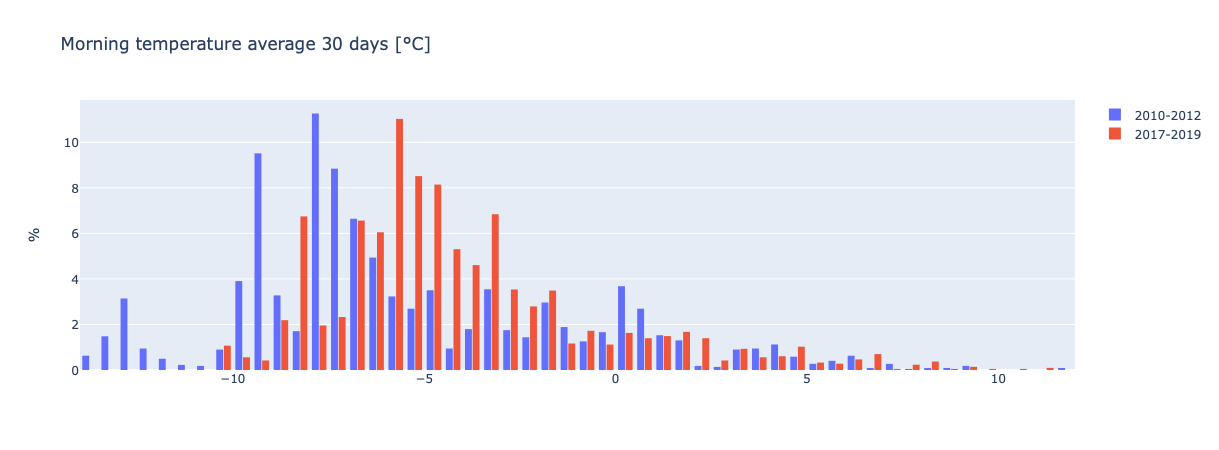

In [208]:
print(f'Mean morning 30 day temperature, for 2010-2012={df_sel_begin.temp_morning_30d.mean():.3g}, for 2017-2019={df_sel_end.temp_morning_30d.mean():.3g}')
fig = go.Figure(layout=dict(title='Morning temperature average 30 days [°C]', bargroupgap=0.1, yaxis=dict(title='%')))
fig.add_histogram(x=df_sel_begin.temp_morning_30d, name='2010-2012', histnorm='percent')
fig.add_histogram(x=df_sel_end.temp_morning_30d, name='2017-2019', histnorm='percent')

Comment:
- No major change on the "skis off" elevation
- No change on the condition rating. Rating is even a bit higher overall in 2017-2019
- Season tends to be shifted: start much later
- Temperature is much above (1.82°C in average)